# Decomposoitions and Plots

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 24 15:05:59 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [4]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

Cloning into 'Tensor-Decompositions-OPM-MEG'...
remote: Enumerating objects: 386, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 386 (delta 32), reused 41 (delta 16), pack-reused 316 (from 1)
Receiving objects: 100% (386/386), 31.26 MiB | 21.41 MiB/s, done.
Resolving deltas: 100% (179/179), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.2 MB/s eta 0:00:00


In [6]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 50.8 MB/s eta 0:00:00


# Outcome

In [87]:
mat_file = 'Outcome_trimmed_TFR_ROI_Averaged.mat'

with h5py.File(mat_file, 'r') as f:
    # Load raw and baseline-normalized tensors
    tensor = np.array(f['tensor'])           # [Trials x ROIs x Freq x Time] - raw power
    tensor_norm = np.array(f['tensor_norm']) # [Trials x ROIs x Freq x Time] - baseline normalized

    time_vec = np.array(f['time_vec']).flatten()
    freq_vec = np.array(f['freq_vec']).flatten()

    # ROI labels (stored as HDF5 references)
    roi_labels = [''.join(chr(c) for c in f[ref][:].flatten()) for ref in f['roi_labels'][:].flatten()]

print(f"Tensor shape (raw): {tensor.shape}")
print(f"Tensor shape (normalized): {tensor_norm.shape}")
print(f"Time: {time_vec[0]*1000:.0f} to {time_vec[-1]*1000:.0f} ms ({len(time_vec)} points)")
print(f"Freq: {freq_vec[0]:.0f} to {freq_vec[-1]:.0f} Hz ({len(freq_vec)} points)")
print(f"ROIs: {len(roi_labels)}")



Tensor shape (raw): (101, 34, 166, 1)
Tensor shape (normalized): (101, 34, 166, 1)
Time: 0 to 1000 ms (101 points)
Freq: 4 to 70 Hz (34 points)
ROIs: 166


In [88]:
tensor = tensor.T
tensor_norm = tensor_norm.T

In [89]:

pow = np.squeeze(tensor_norm, axis=0)
pow.shape

(166, 34, 101)

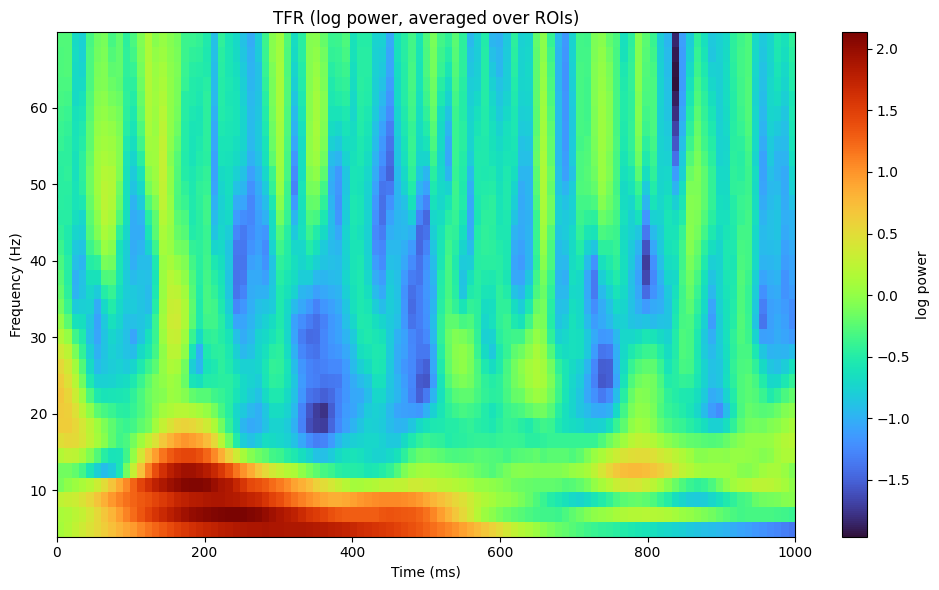

In [90]:
# Average over trials and ROIs
pow_avg = np.nanmean(pow, axis=0)  # [Freq x Time]

plt.figure(figsize=(10, 6))
plt.imshow(pow_avg, aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]],cmap='turbo')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('TFR (log power, averaged over ROIs)')
plt.colorbar(label='log power')
plt.axvline(0, color='white', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:

pow = np.squeeze(tensor, axis=0)
pow.shape

(120, 34, 101)

In [ ]:
Log_pow = np.log(pow)
Log1p_pow = np.log1p(pow)

In [ ]:
np.all(Log_pow > 0)

np.False_

In [ ]:
np.all(Log1p_pow > 0)

np.True_

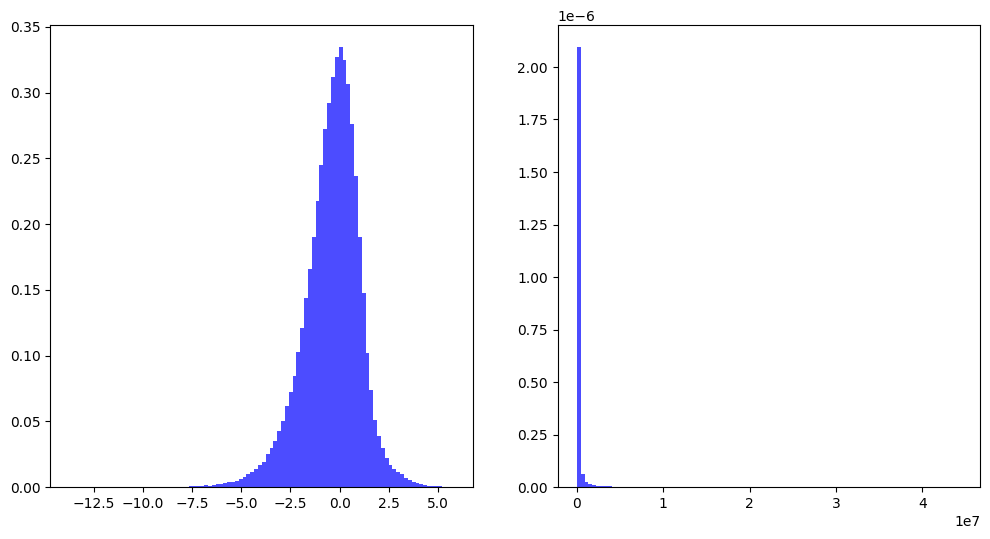

In [11]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].hist(pow.ravel(), bins=100, density=True, color='blue', alpha=0.7);
ax[1].hist(tensor.ravel(), bins=100, density=True, color='blue', alpha=0.7);

In [75]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_pow_torch = torch.as_tensor(pow, device=device, dtype=torch.float32)
log_pow_torch.shape[0]

166

In [16]:
%cd OPM-MEG/Tensor-Decompositions-OPM-MEG/

/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [18]:
from src.tools.rankselection import rank_selection

In [22]:
ranks = range(1,21)

results = rank_selection(log_pow_torch, ranks)


=== Rank 1 ===
--- Testing Rank 1 with 10 repeats (Optimization Stability) ---
Rank 1: Best Error=1010.9908 | Mean Similarity=1.0000
  Run 0: R² = 0.1250
  Run 1: R² = 0.1250
  Run 2: R² = 0.1250
  Run 3: R² = 0.1250
  Run 4: R² = 0.1250
  Run 5: R² = 0.1250
  Run 6: R² = 0.1250
  Run 7: R² = 0.1250
  Run 8: R² = 0.1250
  Run 9: R² = 0.1250
Rank 1: Stability=1.000±0.000, R²=0.125±0.000

=== Rank 2 ===
--- Testing Rank 2 with 10 repeats (Optimization Stability) ---
Rank 2: Best Error=976.6988 | Mean Similarity=0.9429
  Run 0: R² = 0.1832
  Run 1: R² = 0.1832
  Run 2: R² = 0.1832
  Run 3: R² = 0.1832
  Run 4: R² = 0.1832
  Run 5: R² = 0.1832
  Run 6: R² = 0.1832
  Run 7: R² = 0.1832
  Run 8: R² = 0.1832
  Run 9: R² = 0.1832
Rank 2: Stability=0.943±0.028, R²=0.183±0.000

=== Rank 3 ===
--- Testing Rank 3 with 10 repeats (Optimization Stability) ---
Rank 3: Best Error=951.9169 | Mean Similarity=0.8597
  Run 0: R² = 0.2241
  Run 1: R² = 0.2242
  Run 2: R² = 0.2241
  Run 3: R² = 0.2241
  Ru

In [46]:
stabilities = results['stabilities']
stds = results['stab_stds']

fits = results['fits']
fits_stds = results['fit_stds']

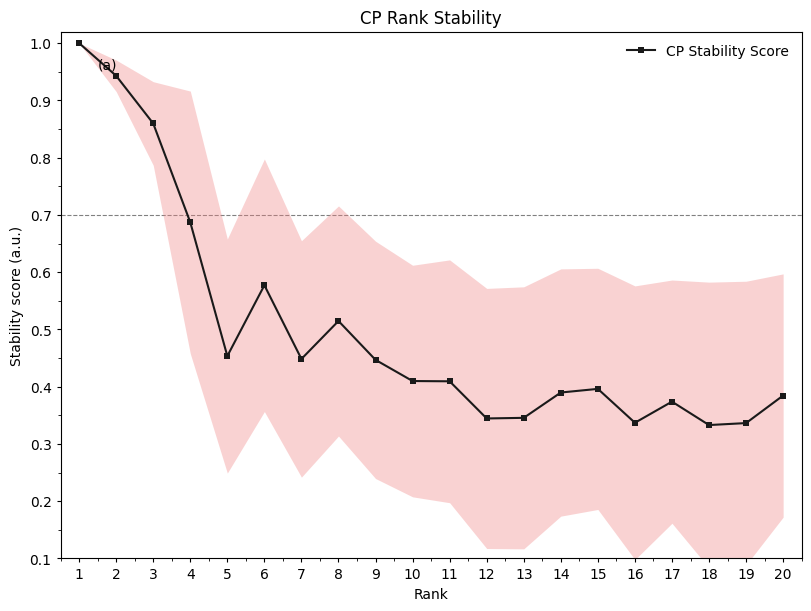

In [33]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(
    figsize=(8, 6),
    constrained_layout=True
)

def panel(a, y, yerr, title, panel_label):
    # Uncertainty as a band
    a.fill_between(
        ranks, y - yerr, y + yerr,
        color="lightcoral", alpha=0.35, linewidth=0, zorder=1
    )

    # Mean line + markers
    a.plot(
        ranks, y, "s-",
        color="0.1",
        markersize=4,
        markerfacecolor="0.1",
        markeredgewidth=0,
        zorder=2,
        label="CP Stability Score"
    )

    # Reference line
    a.axhline(0.7, color="0.5", ls="--", lw=0.8, zorder=0)

    # Axes formatting
    a.set_title(title)
    a.set_xlim(0.5, max(ranks) + 0.5)
    a.set_xticks(ranks)
    a.tick_params(direction="out", length=3, width=0.8)
    a.tick_params(which="minor", direction="out", length=2, width=0.6)

    # Minor ticks without clutter
    a.xaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_minor_locator(AutoMinorLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(0.1))

    # Panel label
    a.text(0.05, 0.95, panel_label, transform=a.transAxes,
           va="top", ha="left")

panel(ax, np.asarray(stabilities), np.asarray(stds),
      "CP Rank Stability", "(a)")

ax.set_ylabel("Stability score (a.u.)")
ax.set_xlabel("Rank")
ax.set_ylim(0.1, 1.02)

# Legend
ax.legend(loc="upper right", frameon=False)

plt.show()

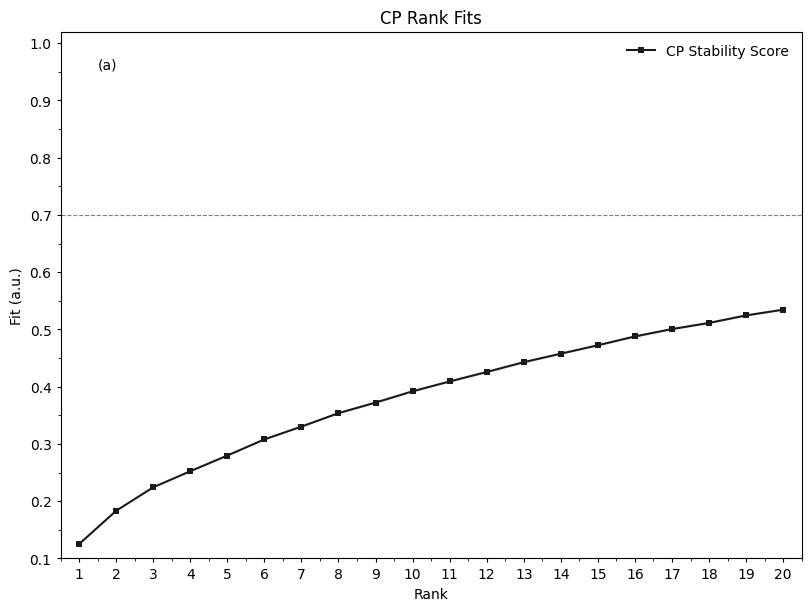

In [47]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(
    figsize=(8, 6),
    constrained_layout=True
)

panel(ax, np.asarray(fits), np.asarray(fits_stds),
      "CP Rank Fits", "(a)")

ax.set_ylabel("Fit (a.u.)")
ax.set_xlabel("Rank")
ax.set_ylim(0.1, 1.02)

# Legend
ax.legend(loc="upper right", frameon=False)

plt.show()

In [71]:
from tensorly.cp_tensor import cp_normalize
from tensorly.decomposition import parafac
import tensorly as tl
tl.set_backend('pytorch')

In [77]:
from tensorly.decomposition import constrained_parafac

# Move to CPU for constrained_parafac (has device issues with CUDA)
tensor_cpu = log_pow_torch.cpu()

weights, factors = constrained_parafac(
    tensor_cpu,
    rank=5,
    init="svd",
    n_iter_max=2000,
    non_negative=[False, True, True],  # [ROI, Freq, Time]
    random_state=42
)

In [58]:
aal_nifti_path = 'AAL3v1_1mm.nii'

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

def to_numpy(x):
    """Safely converts PyTorch Tensors to NumPy arrays."""
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    elif hasattr(x, "numpy"):
        return x.numpy()
    else:
        return np.array(x)


def plot_factors_on_atlas(A, B, C, roi_labels, full_atlas_labels, aal_nifti_path,
                          freq_vec=None, time_vec=None):
    """
    Plot CP factors with NO trial mode.
    Expects:
      A: ROI/spatial weights  (n_rois, R)
      B: Frequency weights    (n_freqs, R)
      C: Time weights         (n_times, R)
    """
    # --- 1. CONVERT INPUTS TO NUMPY ---
    A = to_numpy(A)
    B = to_numpy(B)
    C = to_numpy(C)

    # --- 2. PRE-LOAD ATLAS ---
    aal_img = nib.load(aal_nifti_path)
    aal_data = aal_img.get_fdata()
    affine = aal_img.affine

    R = A.shape[1]

    # Default axes if not provided
    if freq_vec is None:
        freq_vec = np.linspace(0, 70, len(B[:, 0]))
    else:
        freq_vec = to_numpy(freq_vec)

    if time_vec is None:
        time_vec = np.linspace(0, 1000, len(C[:, 0]))
    else:
        time_vec = to_numpy(time_vec) * 1000  # Convert to ms

    for r in range(R):
        # Create figure with gridspec for better control
        fig = plt.figure(figsize=(16, 4.5))
        fig.suptitle(f"Component {r+1}", fontsize=16)

        # Use gridspec: brain plot gets more space
        gs = fig.add_gridspec(1, 3, width_ratios=[1.2, 1, 1], wspace=0.3)

        # --- MODE 1: ROIS (SPATIAL) ---
        roi_weights = A[:, r]
        roi_weights = np.nan_to_num(roi_weights, nan=0.0)

        # Normalize ROI weights to [-2, 2] range
        max_abs = np.max(np.abs(roi_weights))
        if max_abs > 0:
            roi_weights_norm = (roi_weights / max_abs) * 2
        else:
            roi_weights_norm = roi_weights

        brain_vol = np.zeros(aal_data.shape, dtype=float)
        for i, roi_name in enumerate(roi_labels):
            w = float(roi_weights_norm[i])
            try:
                atlas_idx = full_atlas_labels.index(roi_name)
                atlas_id = atlas_idx + 1
                brain_vol[aal_data == atlas_id] = w
            except ValueError:
                pass

        weight_nii = nib.Nifti1Image(brain_vol, affine)

        # Create axis for brain plot
        ax_brain = fig.add_subplot(gs[0])

        # Plot glass brain (note: no vmin parameter, use symmetric_cbar)
        plotting.plot_glass_brain(
            weight_nii,
            axes=ax_brain,
            display_mode="ortho",
            threshold=None,
            colorbar=True,
            plot_abs=False,
            vmax=2,
            symmetric_cbar=True,  # This handles -2 to 2
            cmap="RdBu_r"
        )
        ax_brain.set_title("Spatial (normalized to ±2)")

        # --- MODE 2: FREQUENCY ---
        ax_freq = fig.add_subplot(gs[1])
        ax_freq.plot(freq_vec, B[:, r], color="tab:green", alpha=0.8, linewidth=2)
        ax_freq.fill_between(freq_vec, 0, B[:, r], alpha=0.3, color="tab:green")
        ax_freq.axhline(0, color="k", linewidth=0.5)
        ax_freq.set_title("Frequency")
        ax_freq.set_xlabel("Hz")
        ax_freq.set_ylabel("Weight")
        ax_freq.grid(True, alpha=0.3)

        # --- MODE 3: TIME ---
        ax_time = fig.add_subplot(gs[2])
        ax_time.plot(time_vec, C[:, r], color="k", linewidth=1.5)
        ax_time.fill_between(time_vec, 0, C[:, r], alpha=0.2, color="gray")
        ax_time.axhline(0, color="k", linewidth=0.5)
        ax_time.axvline(0, color="r", linewidth=0.8, linestyle="--", alpha=0.7)
        ax_time.set_title("Time")
        ax_time.set_xlabel("ms")
        ax_time.set_ylabel("Weight")
        ax_time.grid(True, alpha=0.3)

        #plt.tight_layout()
        plt.show()

In [95]:

# weights,  factors = cp_tensor_final
A,B,C = factors

In [42]:
%cd ..

/content/drive/MyDrive/OPM-MEG


In [ ]:
from tensorly.cp_tensor import cp_normalize

In [ ]:
cp_tensor_norm = cp_normalize(cp_tensor_choice)

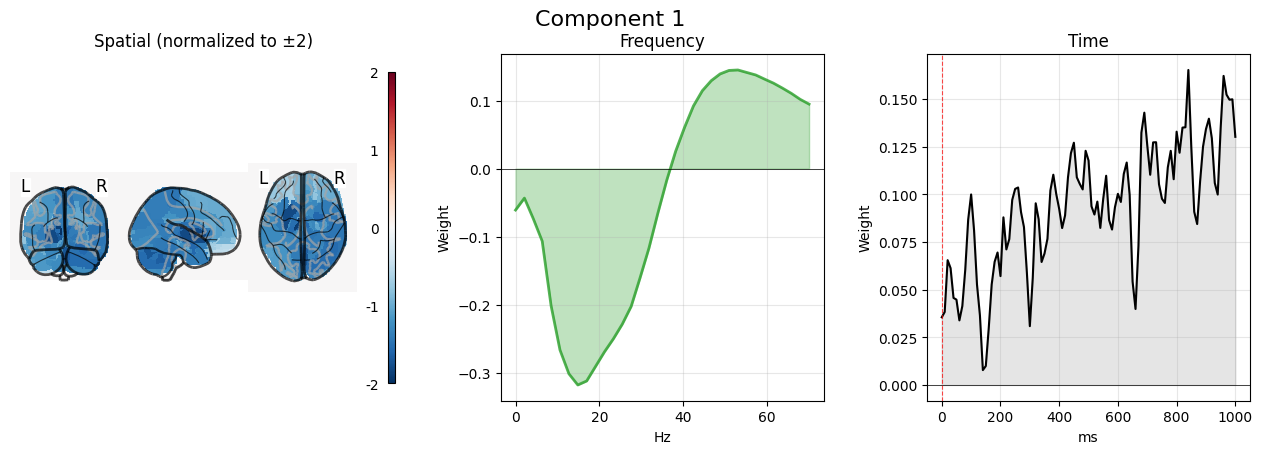

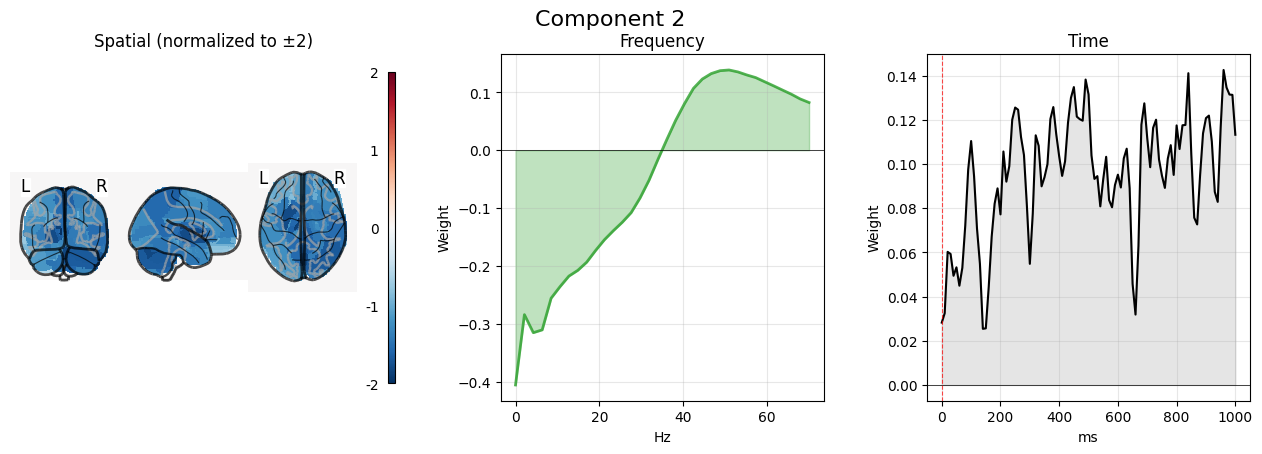

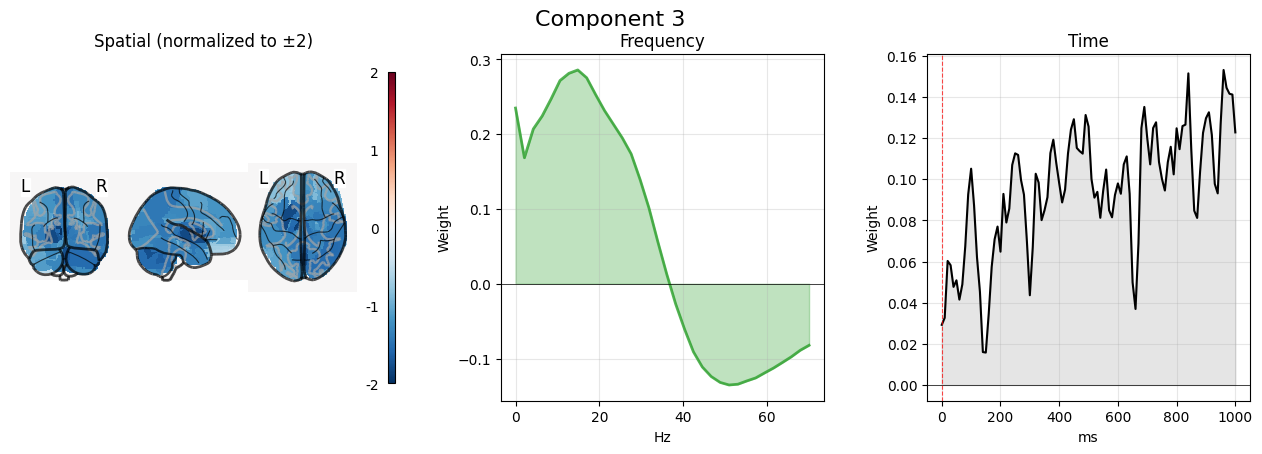

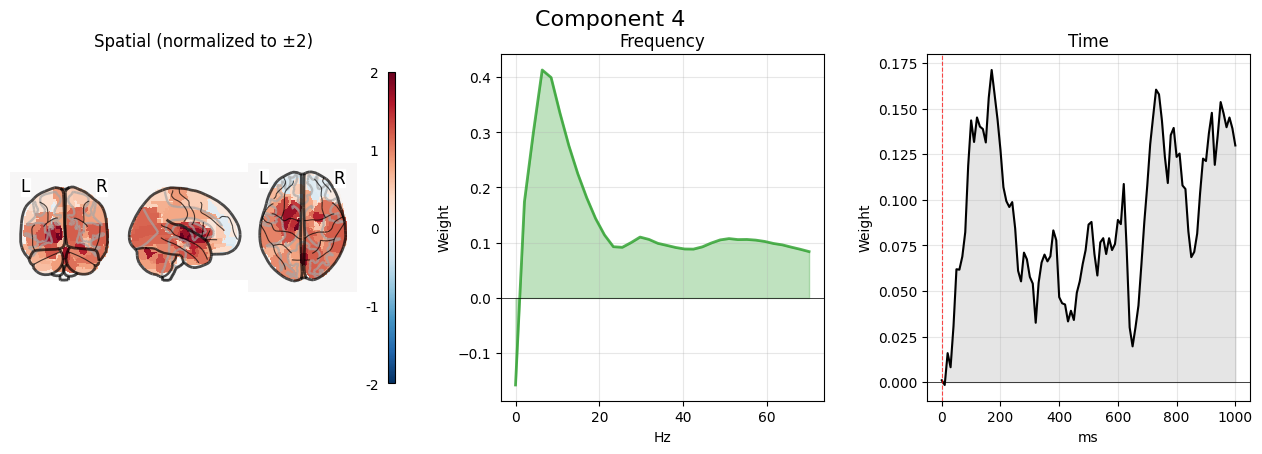

In [94]:
plot_factors_on_atlas(A,B,C,roi_labels, roi_labels, aal_nifti_path)

In [62]:
pp = A[:,1].to('cpu').numpy()

In [63]:
pp.shape

(166,)

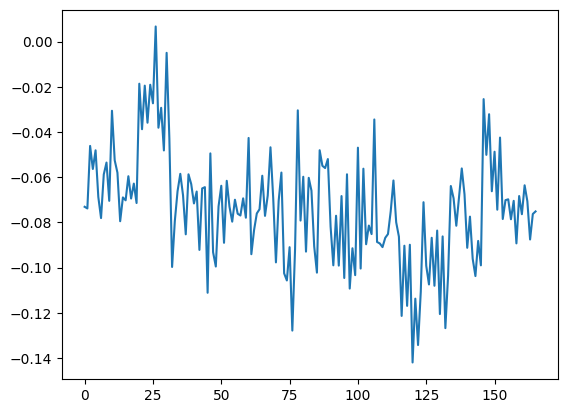

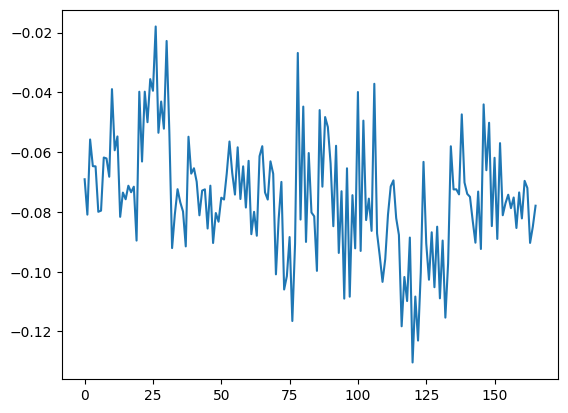

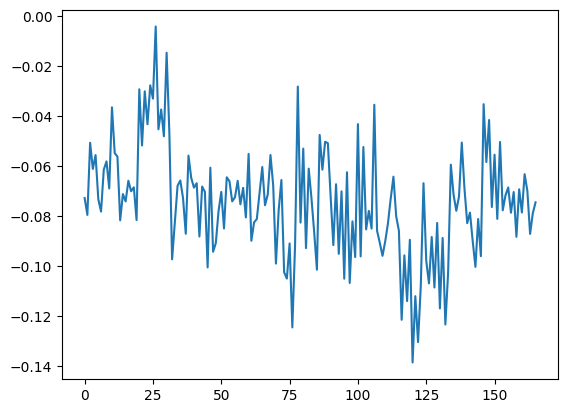

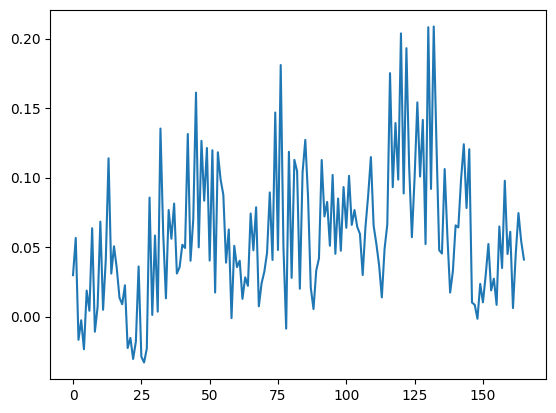

In [64]:
for r in range(A.shape[1]):
  plt.figure()
  plt.plot(A[:,r].to('cpu').numpy())

In [ ]:
%cd Tensor-Decompositions-OPM-MEG/

/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [ ]:
from src.tools.rankselection import rank_stability

In [ ]:
from tqdm import tqdm

In [ ]:
ranks = np.arange(1,5,1)

stabilities = []
stds = []

for i in tqdm(ranks):

    stability,std = rank_stability(log1p_pow_torch,i,n_repeats=5)


    stabilities.append(stability)
    stds.append(std)

 50%|█████     | 2/4 [00:38<00:38, 19.15s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(ranks,stabilities)